# CSE185 Lab 4 Report - Code Documentation (10 pts)

* Document any commands used or additional analysis steps below!
* You should include enough detail that the instructors (or your future self) could come back to this several months from now and know exactly what you did and why you did it.
* We will not run this notebook, but will look back to see what you did especially if you end up with different answers.

For grading purposes only - Do not copy or edit this cell!

In [43]:
# Question 1

cmd1 = """
cat ~/public/lab4/Chow_Rep1.genes.results | head -n 15
"""

# number of genes w/ TPM >0
cmd2 = """
cat ~/public/lab4/Chow_Rep1.genes.results | awk '$6>0 {count++} END {print count}'
cat ~/public/lab4/Chow_Rep2.genes.results | awk '$6>0 {count++} END {print count}'
cat ~/public/lab4/Chow_Rep3.genes.results | awk '$6>0 {count++} END {print count}'
cat ~/public/lab4/HFD_Rep1.genes.results | awk '$6>0 {count++} END {print count}'
cat ~/public/lab4/HFD_Rep2.genes.results | awk '$6>0 {count++} END {print count}'
cat ~/public/lab4/HFD_Rep3.genes.results | awk '$6>0 {count++} END {print count}'
"""

In [44]:
# q2

import matplotlib.pyplot as plt
import numpy as np

# Read TPM values from files
chow_rep1 = np.loadtxt("~/public/lab4/Chow_Rep1.genes.results", usecols=5)
chow_rep2 = np.loadtxt("~/public/lab4/Chow_Rep2.genes.results", usecols=5)
hfd_rep1 = np.loadtxt("~/public/lab4/HFD_Rep1.genes.results", usecols=5)
hfd_rep2 = np.loadtxt("~/public/lab4/HFD_Rep2.genes.results", usecols=5)

# Calculate log10 TPM values (add a small value to avoid log10(0))
chow_rep1_log = np.log10(chow_rep1 + 1e-5)
chow_rep2_log = np.log10(chow_rep2 + 1e-5)
hfd_rep1_log = np.log10(hfd_rep1 + 1e-5)
hfd_rep2_log = np.log10(hfd_rep2 + 1e-5)

# Create scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(chow_rep1_log, chow_rep2_log, alpha=0.5)
ax1.set_xlabel("Chow Rep1 log10 TPM")
ax1.set_ylabel("Chow Rep2 log10 TPM")
ax1.set_title("Chow Rep1 vs. Rep2")

ax2.scatter(hfd_rep1_log, hfd_rep2_log, alpha=0.5)
ax2.set_xlabel("HFD Rep1 log10 TPM")
ax2.set_ylabel("HFD Rep2 log10 TPM")
ax2.set_title("HFD Rep1 vs. Rep2")

plt.tight_layout()
plt.show()

OSError: ~/public/lab4/Chow_Rep1.genes.results not found.

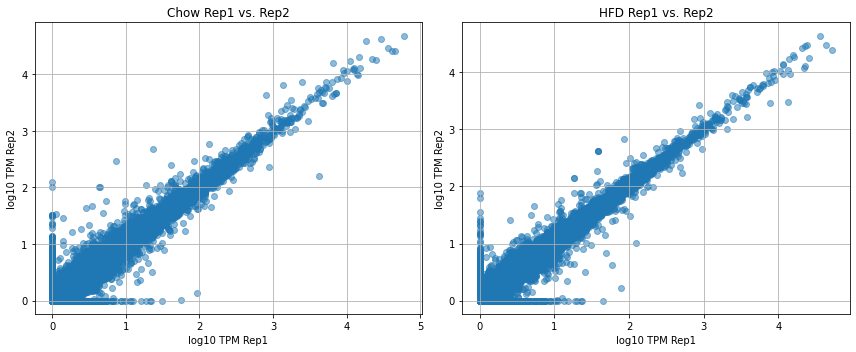

In [45]:
# q2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Read TPM values from files using Pandas
chow_rep1 = pd.read_csv("~/public/lab4/Chow_Rep1.genes.results", sep="\t", usecols=[5])
chow_rep2 = pd.read_csv("~/public/lab4/Chow_Rep2.genes.results", sep="\t", usecols=[5])
hfd_rep1 = pd.read_csv("~/public/lab4/HFD_Rep1.genes.results", sep="\t", usecols=[5])
hfd_rep2 = pd.read_csv("~/public/lab4/HFD_Rep2.genes.results", sep="\t", usecols=[5])

# Calculate log10 TPM values (add a small value to avoid log10(0))
chow_rep1_log = np.log10(chow_rep1 + 1)
chow_rep2_log = np.log10(chow_rep2 + 1)
hfd_rep1_log = np.log10(hfd_rep1 + 1)
hfd_rep2_log = np.log10(hfd_rep2 + 1)

# Create scatter plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(chow_rep1_log, chow_rep2_log, alpha=0.5)
plt.title('Chow Rep1 vs. Rep2')
plt.xlabel('log10 TPM Rep1')
plt.ylabel('log10 TPM Rep2')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(hfd_rep1_log, hfd_rep2_log, alpha=0.5)
plt.title('HFD Rep1 vs. Rep2')
plt.xlabel('log10 TPM Rep1')
plt.ylabel('log10 TPM Rep2')
plt.grid(True)

plt.tight_layout()


# Save figures
plt.savefig('TPM_q2_plots.png')

In [46]:
# Run this to allow using the %%R cell magic
%load_ext rpy2.ipython

# Suppress warnings (most notable from rpy2)
import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [47]:
%%R

##### Load the libraries we need #####
library("DESeq2")
library("tximport")

##### Set up the list of files and metadata #####
files <- c("~/public/lab4/Chow_Rep1.genes.results",
           "~/public/lab4/Chow_Rep2.genes.results", 
           "~/public/lab4/Chow_Rep3.genes.results",
           "~/public/lab4/HFD_Rep1.genes.results",
           "~/public/lab4/HFD_Rep2.genes.results",
           "~/public/lab4/HFD_Rep3.genes.results")

conditions <- c(rep("Chow", 3), rep("HFD", 3))
samples <- data.frame("run"=c("Chow_Rep1", "Chow_Rep2", "Chow_Rep3", "HFD_Rep1", "HFD_Rep2", "HFD_Rep3"),
                      "condition"=conditions)
names(files) = samples$run

##### Import data with tximport #####
txi <- tximport(files, type = "rsem", txIn = FALSE, txOut = FALSE)

# Add pseudocount of 1 to genes with 0 length 
txi$length[txi$length == 0] <- 1

# Create DESeqDataSet object
dds <- DESeqDataSetFromTximport(txi, colData = samples, design = ~ condition)

##### Filter genes with low counts #####
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

##### Perform DESeq2 analysis #####
dds <- DESeq(dds)
res <- results(dds, contrast=c("condition","HFD","Chow"))

##### Write results to file #####
resOrdered <- res[order(res$padj),]
write.csv(as.data.frame(resOrdered), file="chow_vs_hfd_deseq2.csv")

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [60]:
%%R

# Load the utils package (if not already loaded)
library(utils)

# Specify the package name
package_name <- "tximport"

# Get the version of the package
package_version <- packageVersion("tximport")

# Print the package version
cat(sprintf("The version of the '%s' package is: %s\n", package_name, package_version))

The version of the 'tximport' package is: 1.22.0


In [61]:
%%R

# Load the utils package (if not already loaded)
library(utils)

# Specify the package name
package_name <- "DESeq2"

# Get the version of the package
package_version <- packageVersion("DESeq2")

# Print the package version
cat(sprintf("The version of the '%s' package is: %s\n", package_name, package_version))

The version of the 'DESeq2' package is: 1.34.0


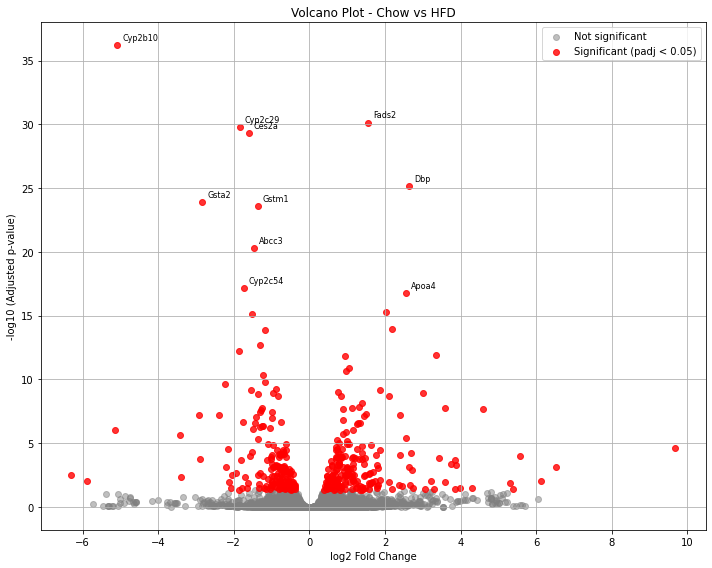

In [52]:
# q3, q4, q5

# Read the DESeq2 results from the CSV file
deseq_results = pd.read_csv("chow_vs_hfd_deseq2.csv")

# Convert gene IDs to gene names using the provided file
gene_names = pd.read_csv("~/public/lab4/GRCm38.75.gene_names", sep="\t", header=None, names=["gene_id", "gene_name"])
deseq_results = deseq_results.merge(gene_names, left_on="Unnamed: 0", right_on="gene_id", how="left")

# Create a new column for the negative logarithm of the adjusted p-value
deseq_results["-log10(padj)"] = -np.log10(deseq_results["padj"])

# Create a boolean mask for significant genes (adjusted p-value < 0.05)
sig_genes = deseq_results["padj"] < 0.05

# Create the volcano plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot non-significant genes in gray
ax.scatter(deseq_results.loc[~sig_genes, "log2FoldChange"], deseq_results.loc[~sig_genes, "-log10(padj)"], color="gray", alpha=0.5, label="Not significant")

# Plot significant genes in red
ax.scatter(deseq_results.loc[sig_genes, "log2FoldChange"], deseq_results.loc[sig_genes, "-log10(padj)"], color="red", alpha=0.8, label="Significant (padj < 0.05)")

# Annotate top differentially expressed genes
top_genes = deseq_results.nlargest(10, "-log10(padj)")
for _, gene in top_genes.iterrows():
    ax.annotate(gene["gene_name"], xy=(gene["log2FoldChange"], gene["-log10(padj)"]), xytext=(5, 5), textcoords="offset points", fontsize=8)

# Set plot labels and title
ax.set_xlabel("log2 Fold Change")
ax.set_ylabel("-log10 (Adjusted p-value)")
ax.set_title("Volcano Plot - Chow vs HFD")

# Add legend
ax.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()


# Save figures
plt.savefig('Volcano_q4.png')

plt.show()

In [53]:
# q5

# Load DESeq2 results
results = pd.read_csv("chow_vs_hfd_deseq2.csv")
# Load gene names mapping
gene_names = pd.read_csv("~/public/lab4/GRCm38.75.gene_names", sep='\t', header=None, names=['GeneID', 'GeneName'])
# Merge gene names with DESeq2 results
results_with_names = pd.merge(results, gene_names, left_on='Unnamed: 0', right_on='GeneID', how='left')
# Set significance threshold
alpha = 0.05
# Filter significantly differentially expressed genes
significant_genes = results_with_names[results_with_names['padj'] < alpha]
# Sort by absolute log2 fold change
significant_genes = significant_genes.reindex(significant_genes['log2FoldChange'].abs().sort_values(ascending=False).index)
# Report number of differentially expressed genes
num_genes = len(significant_genes)
print("Number of differentially expressed genes at 5% FDR:", num_genes)
# Report top 10 differentially expressed genes
print("\nTop 10 most differentially expressed genes(based on log2 fold change):")
print(significant_genes[['GeneName', 'log2FoldChange', 'pvalue']].head(10))

Number of differentially expressed genes at 5% FDR: 375

Top 10 most differentially expressed genes(based on log2 fold change):
    GeneName  log2FoldChange        pvalue
80    Gm5559        9.684341  1.400843e-07
153  Gm12989        6.516617  8.513937e-06
195  Amd-ps3       -6.301708  4.470957e-05
233   Pcdh20        6.126427  1.393911e-04
230    Pram1       -5.892036  1.387983e-04
103    Moxd1        5.585998  7.352253e-07
358    Actg2        5.375119  9.965895e-04
254     Cnn1        5.307675  2.220891e-04
63   Cyp4a14       -5.153649  3.966225e-09
0    Cyp2b10       -5.083951  4.424623e-41


In [54]:
# q5

# Read the DESeq2 results from the CSV file
deseq_results = pd.read_csv("chow_vs_hfd_deseq2.csv")

# Convert gene IDs to gene names using the provided file
gene_names = pd.read_csv("~/public/lab4/GRCm38.75.gene_names", sep="\t", header=None, names=["gene_id", "gene_name"])
deseq_results = deseq_results.merge(gene_names, left_on="Unnamed: 0", right_on="gene_id", how="left")

# Count the number of differentially expressed genes at FDR < 0.05
num_diff_expressed = (deseq_results["padj"] < 0.05).sum()
print(f"Number of differentially expressed genes at FDR < 0.05: {num_diff_expressed}")

# Get the top 10 most differentially expressed genes
top_genes = deseq_results.nsmallest(10, "padj")

# Print the top 10 genes with their gene names, log2 fold change, and p-values
print("Top 10 most differentially expressed genes(based on p-value):")
print(top_genes[["gene_name", "log2FoldChange", "pvalue"]])

Number of differentially expressed genes at FDR < 0.05: 375
Top 10 most differentially expressed genes(based on p-value):
  gene_name  log2FoldChange        pvalue
0   Cyp2b10       -5.083951  4.424623e-41
1     Fads2        1.545719  9.952204e-35
2   Cyp2c29       -1.835318  3.565345e-34
3     Ces2a       -1.600727  1.280916e-33
4       Dbp        2.637427  2.367820e-29
5     Gsta2       -2.837015  4.808465e-28
6     Gstm1       -1.360523  1.148110e-27
7     Abcc3       -1.457844  2.788198e-24
8   Cyp2c54       -1.732744  4.001637e-21
9     Apoa4        2.544864  1.192791e-20


In [68]:
# q6


results = pd.read_csv("chow_vs_hfd_deseq2.csv")
# Define foreground and background gene lists
up_regulated = results[(results['log2FoldChange'] > 0) & (results['padj'] < 0.05)]['Unnamed: 0']
down_regulated = results[(results['log2FoldChange'] < 0) & (results['padj'] < 0.05)]['Unnamed: 0']
background = results['Unnamed: 0']

# Save gene lists to files
up_regulated.to_csv("foreground_up_genes.txt", index=False, header=False)
down_regulated.to_csv("foreground_down_genes.txt", index=False, header=False)
background.to_csv("background_genes.txt", index=False, header=False)
